<a href="https://colab.research.google.com/github/haricodez1297/image-cipher/blob/main/modelanaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving house.tiff to house.tiff


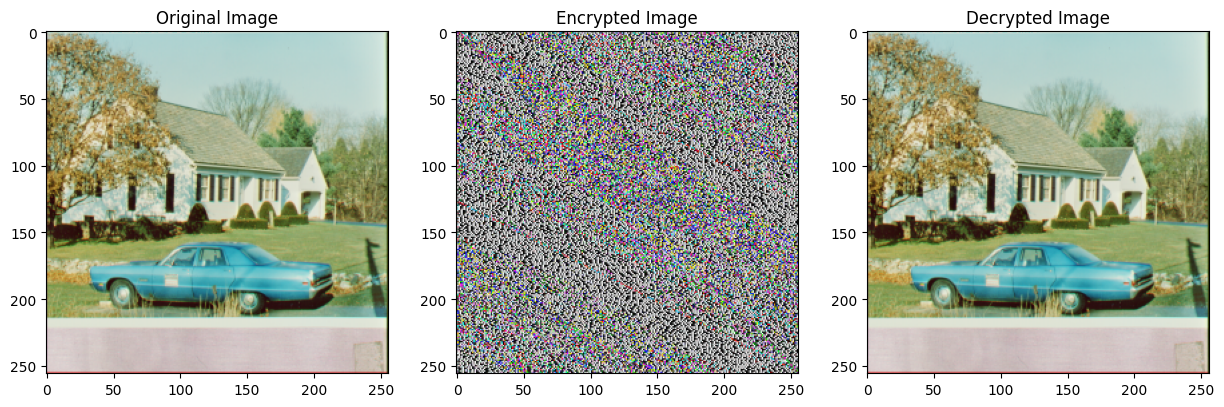

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files

# Function to generate a magic square (only works for odd n)
def generate_magic_square(n):
    if n % 2 == 0:
        raise ValueError("Magic square is only defined for odd order n.")
    magic_square = np.zeros((n, n), dtype=int)
    num = 1
    i, j = 0, n // 2

    while num <= n**2:
        magic_square[i, j] = num
        num += 1
        newi, newj = (i-1) % n, (j+1) % n

        if magic_square[newi, newj]:
            i += 1
        else:
            i, j = newi, newj

    return magic_square

# Function for differential encoding
def differential_encoding(image, reference_bit=128):
    encoded_image = np.zeros_like(image)
    encoded_image[:, 0] = np.bitwise_xor(image[:, 0], reference_bit)

    for i in range(1, image.shape[1]):
        encoded_image[:, i] = np.bitwise_xor(image[:, i], image[:, i - 1])

    return encoded_image

# Function for differential decoding (reverse of differential encoding)
def differential_decoding(encoded_image, reference_bit=128):
    decoded_image = np.zeros_like(encoded_image)
    decoded_image[:, 0] = np.bitwise_xor(encoded_image[:, 0], reference_bit)

    for i in range(1, encoded_image.shape[1]):
        decoded_image[:, i] = np.bitwise_xor(encoded_image[:, i], decoded_image[:, i - 1])

    return decoded_image

# Logistic map for generating chaotic sequences
def logistic_map(x, r=3.99):
    return r * x * (1 - x)

# Generate a chaotic sequence
def generate_chaotic_sequence(length, x0):
    sequence = []
    x = x0
    for i in range(length):
        x = logistic_map(x)
        sequence.append(x)
    return np.array(sequence)

# Function to perform 2D Arnold scrambling
def arnold_scramble(image, num_iterations):
    N = image.shape[0]
    scrambled_image = np.copy(image)

    for _ in range(num_iterations):
        new_image = np.zeros_like(image)
        for x in range(N):
            for y in range(N):
                new_x = (x + y) % N
                new_y = (x + 2*y) % N
                new_image[new_x, new_y] = scrambled_image[x, y]
        scrambled_image = new_image

    return scrambled_image

# Function to reverse 2D Arnold scrambling
def arnold_unscramble(image, num_iterations):
    N = image.shape[0]
    unscrambled_image = np.copy(image)

    for _ in range(num_iterations):
        new_image = np.zeros_like(image)
        for x in range(N):
            for y in range(N):
                new_x = (2*x - y) % N
                new_y = (-x + y) % N
                new_image[new_x, new_y] = unscrambled_image[x, y]
        unscrambled_image = new_image

    return unscrambled_image

# XOR operation
def xor_operation(image, chaotic_sequence):
    return np.bitwise_xor(image, chaotic_sequence)

# Circular shift function
def circular_shift(image, shift_value):
    return np.roll(image, shift_value, axis=1)

# Full encryption process for color images
def encrypt_image(image, reference_bit=128, x0=0.5, r=3.99):
    height, width, channels = image.shape
    encrypted_image = np.zeros_like(image)

    for c in range(channels):
        # Step 1: Scramble the original image channel using Arnold scrambling
        scrambled_channel = arnold_scramble(image[:, :, c], num_iterations=1)

        # Step 2: Generate the magic square and scramble it if n is odd
        if height % 2 == 1:
            magic_square = generate_magic_square(height)
            scrambled_magic_square = arnold_scramble(magic_square, num_iterations=1)

            # Select values from magic square based on scrambled channel pixels
            selected_magic_values = scrambled_magic_square[np.arange(height), scrambled_channel.flatten() % height].reshape(height, width)

            # Apply differential encoding using the selected magic values and reference bit
            diff_encoded_channel = differential_encoding(selected_magic_values, reference_bit=reference_bit)
        else:
            diff_encoded_channel = differential_encoding(scrambled_channel, reference_bit=reference_bit)

        # Step 3: Generate Chaotic Sequence
        chaotic_sequence = generate_chaotic_sequence(height * width, x0).reshape(height, width)

        # Step 4: XOR Operation
        xor_channel = xor_operation(diff_encoded_channel, (chaotic_sequence * 255).astype(np.uint8))

        # Step 5: Circular Shift
        encrypted_image[:, :, c] = circular_shift(xor_channel, shift_value=1)

    return encrypted_image

# Full decryption process for color images
def decrypt_image(encrypted_image, reference_bit=128, x0=0.59, r=3.99):
    height, width, channels = encrypted_image.shape
    decrypted_image = np.zeros_like(encrypted_image)

    for c in range(channels):
        # Reverse Circular Shift
        unshifted_channel = circular_shift(encrypted_image[:, :, c], shift_value=-1)

        # Reverse XOR Operation
        chaotic_sequence = generate_chaotic_sequence(height * width, x0).reshape(height, width)
        xor_channel = xor_operation(unshifted_channel, (chaotic_sequence * 255).astype(np.uint8))

        # Reverse Differential Encoding
        decoded_channel = differential_decoding(xor_channel, reference_bit=reference_bit)

        # If magic square was used, unscramble it
        if height % 2 == 1:
            magic_square = generate_magic_square(height)
            scrambled_magic_square = arnold_scramble(magic_square, num_iterations=1)
            selected_magic_values = scrambled_magic_square[np.arange(height), decoded_channel.flatten() % height].reshape(height, width)
            decrypted_image[:, :, c] = arnold_unscramble(selected_magic_values, num_iterations=1)
        else:
            decrypted_image[:, :, c] = arnold_unscramble(decoded_channel, num_iterations=1)

    return decrypted_image

# Step 1: Upload the Image
uploaded = files.upload()

# Get the filename of the uploaded image
image_path = list(uploaded.keys())[0]

# Step 2: Load and preprocess the image
image = cv2.imread(image_path)

# Check if the image was loaded correctly
if image is None:
    print(f"Error: Unable to load image at {image_path}. Please check the path and try again.")
else:
    # Resize the image for simplicity
    image = cv2.resize(image, (256, 256))

plt.figure(figsize=(15, 5))

# Display Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Encrypt the image
encrypted_image = encrypt_image(image)

# Display Encrypted Image
plt.subplot(1, 3, 2)
plt.title("Encrypted Image")
plt.imshow(cv2.cvtColor(encrypted_image, cv2.COLOR_BGR2RGB))

# Decrypt the image
decrypted_image = decrypt_image(encrypted_image, reference_bit=128, x0=0.5, r=3.99)

# Display Decrypted Image
plt.subplot(1, 3, 3)
plt.title("Decrypted Image")
plt.imshow(cv2.cvtColor(decrypted_image, cv2.COLOR_BGR2RGB))

# Show the plot
plt.show()

In [ ]:
import time

start_time = time.time()
encrypted_image = encrypt_image(image)
encryption_time = time.time() - start_time
print(f"Encryption time: {encryption_time} seconds")


Encryption time: 0.21009373664855957 seconds


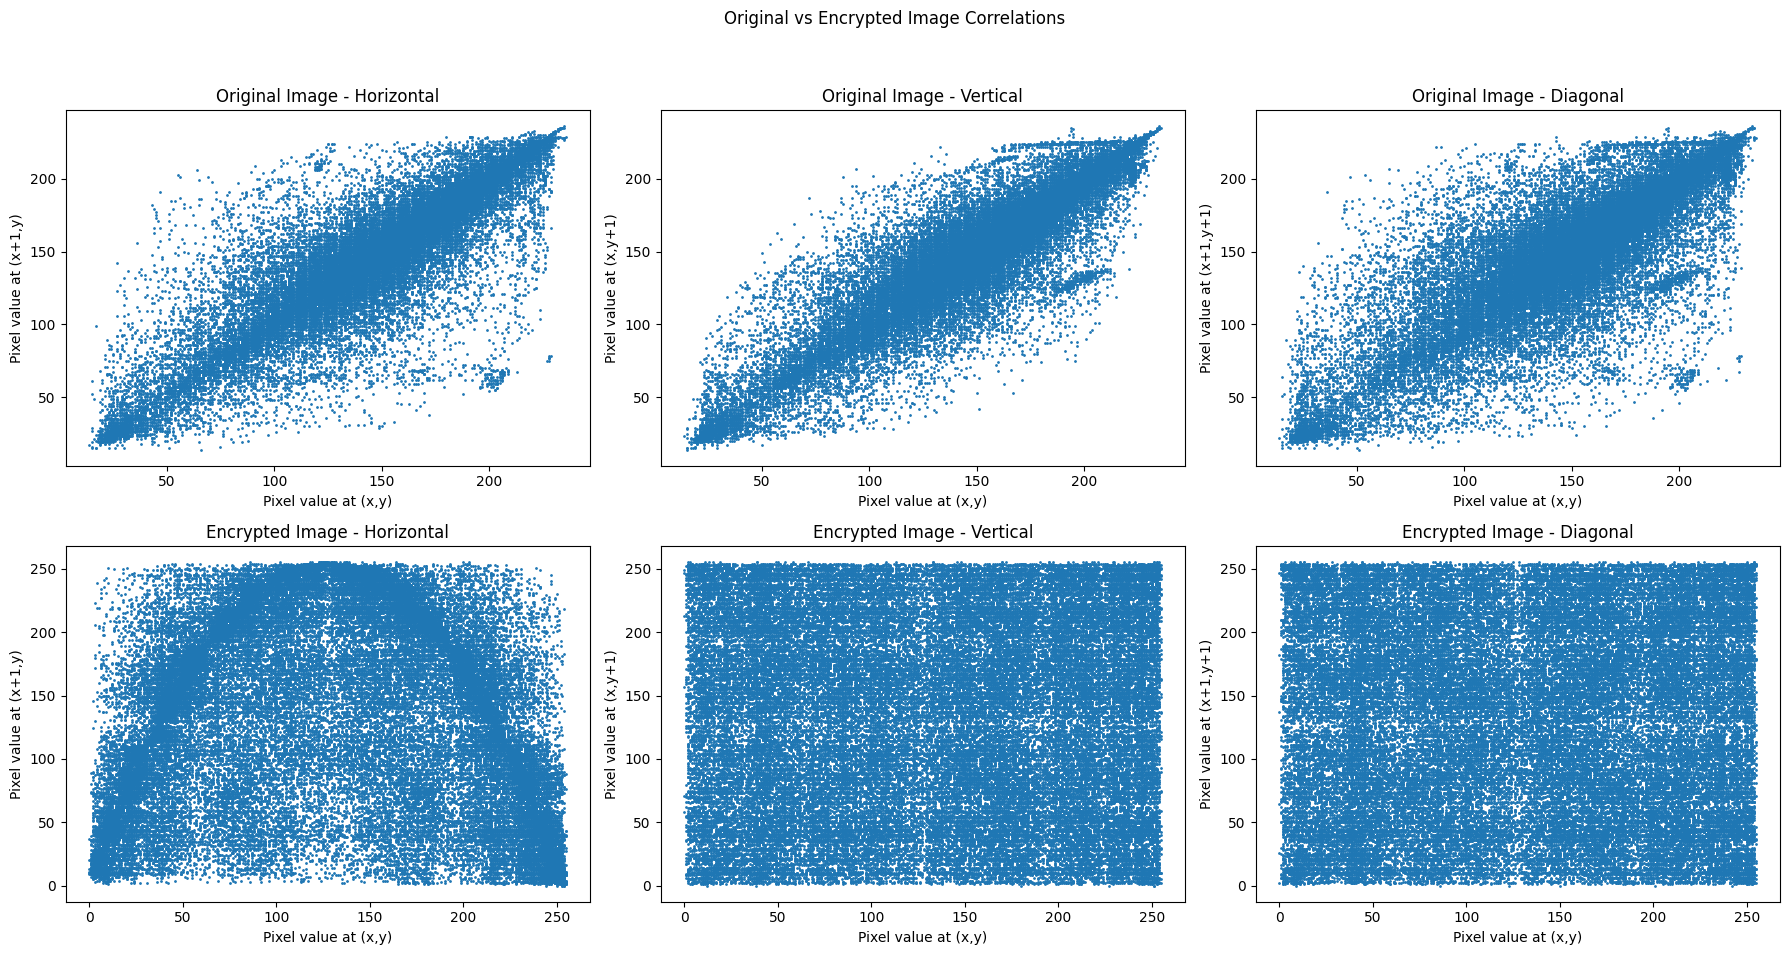

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Convert images to grayscale for correlation analysis
gray_original = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_encrypted = cv2.cvtColor(encrypted_image, cv2.COLOR_BGR2GRAY)

# Function to plot correlations
def plot_correlations(original, encrypted, title_prefix):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"{title_prefix} Image Correlations")

    for i, (img, title) in enumerate(zip([original, encrypted], ["Original Image", "Encrypted Image"])):
        # Horizontal correlation
        x = img[:, :-1].flatten()
        y = img[:, 1:].flatten()
        axes[i, 0].scatter(x, y, s=1)
        axes[i, 0].set_title(f"{title} - Horizontal")
        axes[i, 0].set_xlabel("Pixel value at (x,y)")
        axes[i, 0].set_ylabel("Pixel value at (x+1,y)")

        # Vertical correlation
        x = img[:-1, :].flatten()
        y = img[1:, :].flatten()
        axes[i, 1].scatter(x, y, s=1)
        axes[i, 1].set_title(f"{title} - Vertical")
        axes[i, 1].set_xlabel("Pixel value at (x,y)")
        axes[i, 1].set_ylabel("Pixel value at (x,y+1)")

        # Diagonal correlation
        x = img[:-1, :-1].flatten()
        y = img[1:, 1:].flatten()
        axes[i, 2].scatter(x, y, s=1)
        axes[i, 2].set_title(f"{title} - Diagonal")
        axes[i, 2].set_xlabel("Pixel value at (x,y)")
        axes[i, 2].set_ylabel("Pixel value at (x+1,y+1)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot correlation for original and encrypted images
plot_correlations(gray_original, gray_encrypted, "Original vs Encrypted")


In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def calculate_psnr_ssim(image, encrypted_image):
    # Calculate PSNR
    psnr_value = peak_signal_noise_ratio(image, encrypted_image, data_range=255)

    # Set win_size to a smaller value if the images are small
    win_size = min(image.shape[0], image.shape[1], 7)
    if win_size % 2 == 0:
        win_size -= 1  # Ensure win_size is odd

    # Calculate SSIM (handle color channels if present)
    if image.shape[-1] == 3:  # Check if the image has 3 channels (color)
        ssim_value = structural_similarity(image, encrypted_image, win_size=win_size, data_range=255, channel_axis=-1)
    else:
        ssim_value = structural_similarity(image, encrypted_image, win_size=win_size, data_range=255)

    return psnr_value, ssim_value

# Calculate PSNR and SSIM
psnr_value, ssim_value = calculate_psnr_ssim(image, encrypted_image)

print("PSNR:", psnr_value)
print("SSIM:", ssim_value)


PSNR: 8.059114299776338
SSIM: 0.006186588364083732


In [ ]:
import numpy as np
import cv2

# Function to calculate information entropy
def calculate_entropy(image):
    # Convert to grayscale if the image is colored
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Calculate histogram and probabilities
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    probabilities = histogram / np.sum(histogram)

    # Calculate entropy
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy

# Calculate entropy for each image
entropy_original = calculate_entropy(image)
entropy_encrypted = calculate_entropy(encrypted_image)

# Print the entropy values
print(f"Entropy of the original image: {entropy_original:.4f}")
print(f"Entropy of the encrypted image: {entropy_encrypted:.4f}")

Entropy of the original image: 7.2844
Entropy of the encrypted image: 7.9604


NPCR: 99.68617757161459 %
UACI: 32.613036710452405 %


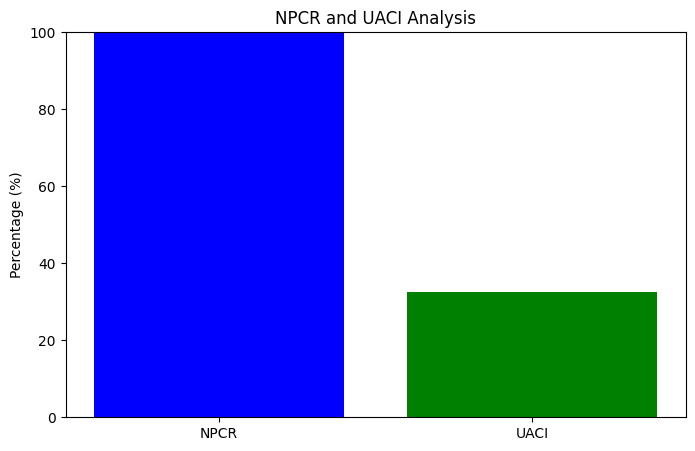

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_npcr_uaci(image, encrypted_image):

    # Ensure both images have the same dimensions
    assert image.shape == encrypted_image.shape, "Images must have the same dimensions."

    # Calculate NPCR
    change_count = np.sum(image != encrypted_image)
    total_pixels = image.size
    npcr = (change_count / total_pixels) * 100

    # Calculate UACI
    diff_intensity = np.abs(image.astype(np.int32) - encrypted_image.astype(np.int32))
    uaci = np.mean(diff_intensity) / 255 * 100

    return npcr, uaci

def plot_npcr_uaci(npcr, uaci):


    metrics = ['NPCR', 'UACI']
    values = [npcr, uaci]

    plt.figure(figsize=(8, 5))
    plt.bar(metrics, values, color=['blue', 'green'])
    plt.ylim(0, 100)  # Set y-axis limit to 100%
    plt.ylabel("Percentage (%)")
    plt.title("NPCR and UACI Analysis")
    plt.show()



npcr_value, uaci_value = calculate_npcr_uaci(image, encrypted_image)
print("NPCR:", npcr_value, "%")
print("UACI:", uaci_value, "%")

plot_npcr_uaci(npcr_value, uaci_value)


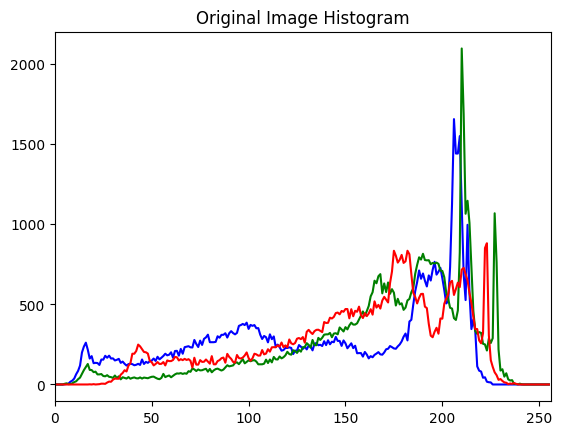

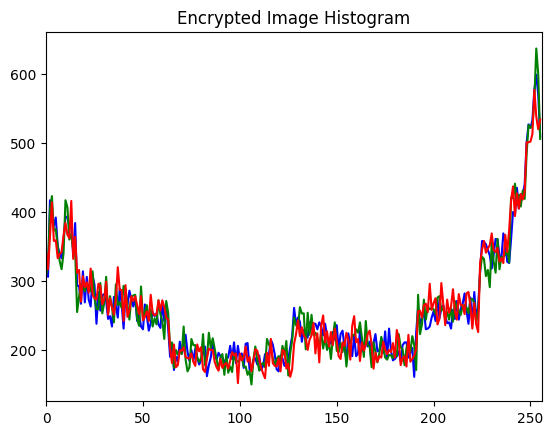

In [ ]:
def plot_histogram(image, title):
    color = ('b', 'g', 'r')
    for i, col in enumerate(color):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
    plt.title(title)
    plt.show()

plot_histogram(image, "Original Image Histogram")
plot_histogram(encrypted_image, "Encrypted Image Histogram")


In [ ]:
import numpy as np

# Define the parameters
k1 = 1  # Replace with the specific value for k1 if known
k3 = 1  # Replace with the specific value for k3 if known
b = 2   # Bit-size per element in the magic square, adjust based on the encryption requirements
m = 4   # Order of the magic square, adjust as per requirements
sub_key_k2 = (2 ** b) ** (m**2)  # Calculate size of sub-key k2

# Given precision and sub-key for PWLCM-based parameters
sub_key_k4 = (10 ** 15) ** 3 * (10 ** 15) ** 3  # As per the project's precision and size

# Total key space formula
total_key_space = k1 * sub_key_k2 * k3 * sub_key_k4
total_key_space_e = "{:.2e}".format(total_key_space)  # Convert to scientific notation

print(f"Total Key Space: {total_key_space_e}")




Total Key Space: 4.29e+99
